# **Introduction to Machine learning for astronomers in Python**




# 3. hands-on session: **Classification problem: from *Data* to *Inference***

## **Contents**

1. Obtain (good) data
1. Preprocess the data
1. Select features & reduce dimensions
1. Find best hyperparameters
1. Closs-validate
1. Compare classifiers
1. Combine classifiers
1. Predict

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Obtain (good) data**

- enough datapoints
- distinguishable features
- not so much omitted datapoints
- representant dataset
- unbiased dataset

### **Random points**

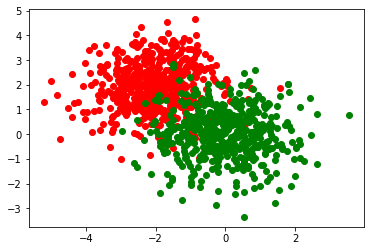

In [2]:
# generate data
dist1 = np.random.multivariate_normal([-2, 2], [[1, 0], [0, 1]], size=500)
dist2 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=500)

# plot data
plt.scatter(dist1[:, 0], dist1[:, 1], color='red')
plt.scatter(dist2[:, 0], dist2[:, 1], color='green');

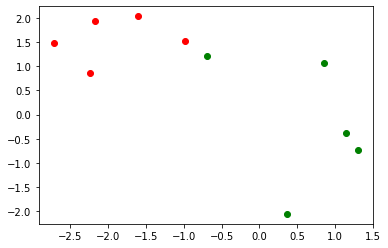

In [3]:
# generate data
dist1 = np.random.multivariate_normal([-2, 2], [[1, 0], [0, 1]], size=5)
dist2 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=5)

# plot data
plt.scatter(dist1[:, 0], dist1[:, 1], color='red')
plt.scatter(dist2[:, 0], dist2[:, 1], color='green');

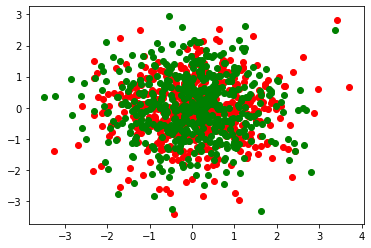

In [4]:
# generate data
dist1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=500)
dist2 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=500)

# plot data
plt.scatter(dist1[:, 0], dist1[:, 1], color='red')
plt.scatter(dist2[:, 0], dist2[:, 1], color='green');

,Height,Width,Species
0,36,nan,Dog
1,46,14,Dog
2,29,30,Dog
3,49,nan,Dog
4,27,29,Dog
5,25,24,Dog
6,18,nan,Dog
7,48,23,Dog
8,45,9.2,Dog
9,31,nan,Dog


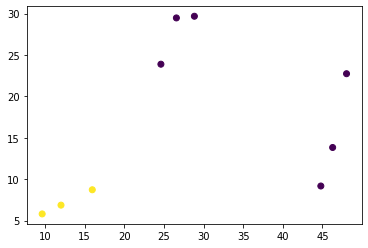

In [5]:
X1 = np.hstack((np.random.uniform(15, 50, size=10), 
                np.random.uniform(5, 20, size=4)))

X2 = np.hstack((np.random.uniform(8, 30, size=10), 
                np.random.uniform(3, 10, size=4)))

X2[::3] = np.nan

y = 10*["Dog"] + 4*["Cat"]
labels = 10*[0] + 4*[1]

plt.scatter(X1, X2, c=labels)

pd.options.display.float_format = "{:,.2g}".format
pd.DataFrame({"Height" : X1, "Width" : X2, "Species" : y})

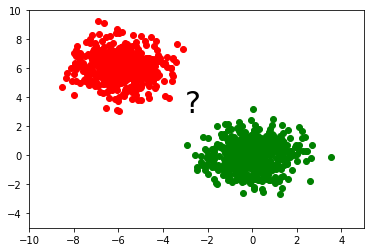

In [6]:
# generate data
dist1 = np.random.multivariate_normal([-6, 6], [[1, 0], [0, 1]], size=500)
dist2 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=500)

# plot data
plt.scatter(dist1[:, 0], dist1[:, 1], color='red')
plt.scatter(dist2[:, 0], dist2[:, 1], color='green');

plt.xlim(-10, 5)
plt.ylim(-5, 10)
plt.text(-3, 3, "?", fontsize=30);

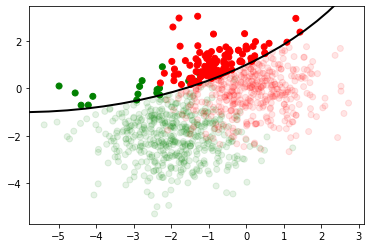

In [7]:
# generate data
dist1 = np.random.multivariate_normal([-2, -2], [[1, 0], [0, 1]], size=500)
dist2 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=500)

# plot data
x0, y0, r = -6, 9, 10
opacities1 = np.where(np.sqrt((dist1[:,0]-x0)**2 + (dist1[:,1]-y0)**2) < r, 1, 0.1)
colors1 = np.ones((500,3)) * np.array([0, 128, 0]) / 255
colors1 = np.column_stack((colors1, opacities1))

opacities2 = np.where(np.sqrt((dist2[:,0]-x0)**2 + (dist2[:,1]-y0)**2) < r, 1, 0.1)
colors2 = np.ones((500,3)) * np.array([255, 0, 0]) / 255
colors2 = np.column_stack((colors2, opacities2))

fig, ax = plt.subplots()
ax.scatter(dist1[:, 0], dist1[:, 1], c=colors1)
ax.scatter(dist2[:, 0], dist2[:, 1], c=colors2);

circle = plt.Circle((x0, y0), r, color="black", fill=False, lw=2)
ax.add_artist(circle);

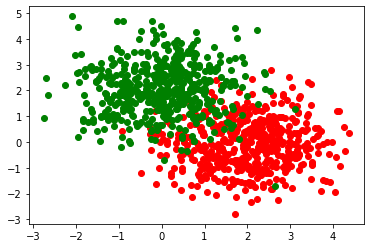

In [8]:
# generate data
dist1 = np.random.multivariate_normal([2, 0], [[1, 0], [0, 1]], size=500)
dist2 = np.random.multivariate_normal([0, 2], [[1, 0], [0, 1]], size=500)

# plot data
plt.scatter(dist1[:, 0], dist1[:, 1], color='red')
plt.scatter(dist2[:, 0], dist2[:, 1], color='green');

### **Random points with scikit-learn**

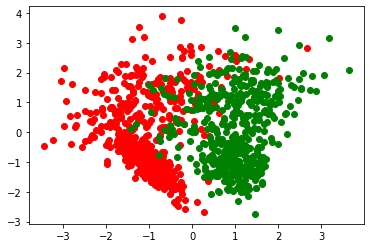

In [9]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, 
                           n_classes=2, 
                           n_features=2, 
                           n_informative=2, 
                           n_redundant=0, 
                           random_state=666)

i1, i2 = y == 0, y == 1

plt.scatter(X[:, 0][i1], X[:, 1][i1], color='red')
plt.scatter(X[:, 0][i2], X[:, 1][i2], color='green');

### **[Scikit-learn datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html)**

#### **Iris dataset**

![](https://www.aifunded.es/images/iris.png)

(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'])

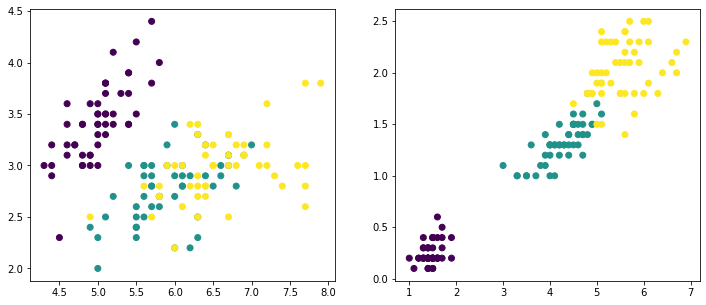

In [10]:
from sklearn.datasets import load_iris # kosatec

iris = load_iris()
X, y = iris["data"], iris["target"]

#X, y = load_iris(return_X_y = True)

i1, i2, i3 = y==0, y==1, y==2

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c=y)

iris["target_names"], iris["feature_names"]

In [11]:
!pip install corner
import corner

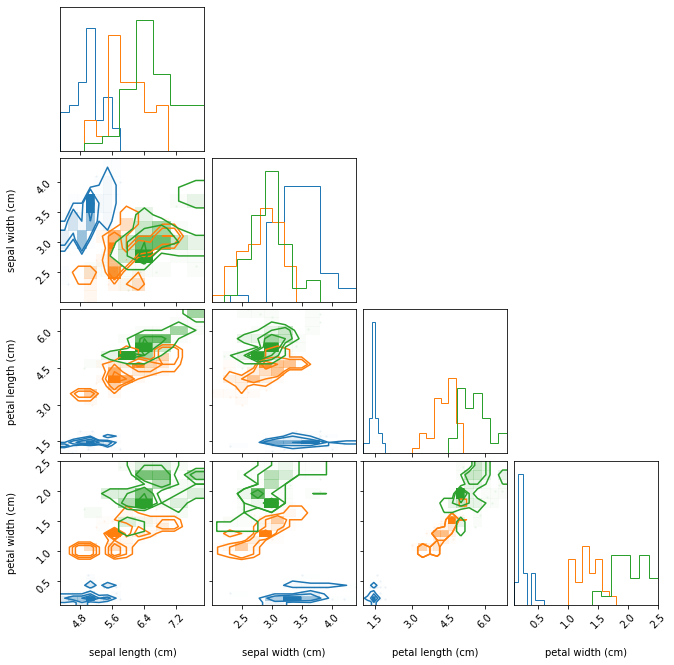

In [12]:
df = pd.DataFrame(data=iris["data"],
                  columns=iris["feature_names"])

df_1 = df[iris["target"] == 0]
df_2 = df[iris["target"] == 1]
df_3 = df[iris["target"] == 2]

kw = {"bins" : [7, 7, 7, 7]}
fig = corner.corner(df_1, color="C0", **kw)
corner.corner(df_2, fig=fig, color="C1", **kw)
corner.corner(df_3, fig=fig, color="C2", **kw);

#### **Digits**

(1797, 64)

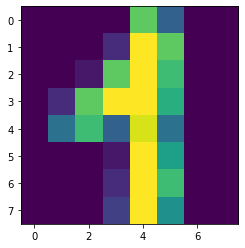

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
plt.imshow(digits.data[42].reshape(8,8));
digits.data.shape

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

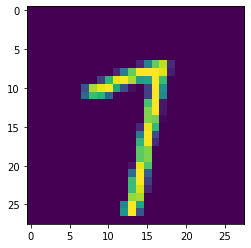

In [14]:
from keras.datasets import mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

plt.imshow(x_train[42]);
x_train.shape

#### **Califoria housing prices dataset**

In [15]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X = pd.DataFrame(data["data"], columns=data['feature_names'])
X["MedHouseVal"] = data["target"]

pd.reset_option("display.float_format")
X

INFO:sklearn.datasets._california_housing:Downloading Cal. housing from https://ndownloader.figshare.com/files/5976036 to /root/scikit_learn_data


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


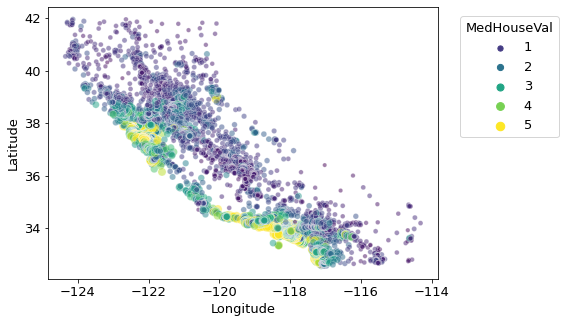

In [16]:
import seaborn as sns

plt.figure(figsize=(7,5))
plt.rc("font", size=13)
sns.scatterplot(data=X, x="Longitude", y="Latitude",
                size="MedHouseVal", hue="MedHouseVal",
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.04, 0.99), loc="upper left");

### **Other datasets**

[Scikit-learn](https://scikit-learn.org/stable/datasets/toy_dataset.html)

[Keras](https://keras.io/api/datasets/)

[Kaggle](https://www.kaggle.com/datasets)

[OpenML](https://www.openml.org/search?type=data)

### **Our dataset**

SDSS data of point sources: stars vs Quasi-stellar objects

<img src="https://cdn.mos.cms.futurecdn.net/HgaCHZDNppE6e52yeDACo6-970-80.jpg.webp" height=200>

<img src="https://earthsky.org/upl/2021/01/supermassive-black-hole-artist-e1610556964639.jpg" height=200 align=right>



In [17]:
!wget -c "https://drive.google.com/uc?id=1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB" -O "sdss_photo.csv"

--2021-11-04 21:05:30--  https://drive.google.com/uc?id=1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB
Resolving drive.google.com (drive.google.com)... 142.251.31.139, 142.251.31.101, 142.251.31.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.31.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f90eege5l0kdtot1lb2h5mlmntq0b62i/1636059900000/12667160157784747384/*/1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB [following]
--2021-11-04 21:05:30--  https://doc-04-2s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f90eege5l0kdtot1lb2h5mlmntq0b62i/1636059900000/12667160157784747384/*/1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB
Resolving doc-04-2s-docs.googleusercontent.com (doc-04-2s-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to doc-04-2s-docs.googleusercontent.com (doc-04-2s-docs.googleusercontent.com)|108.1

In [18]:
data = pd.read_csv("sdss_photo.csv")

## **Data preprocessing**

### What to do with the data:
- look at the data
- check data quality
- understand the data
- think of selection biases

In [19]:
data

,mag_u,mag_g,mag_r,mag_i,mag_z,target,u-g,g-r,r-i,i-z
0,19.240999,17.525999,16.840000,16.613001,16.492001,star,1.715000,0.685999,0.226999,0.121000
1,19.732000,18.339001,17.767000,17.580000,17.481001,star,1.393000,0.572001,0.187000,0.098999
2,16.120001,15.232000,14.933000,14.845000,14.827000,star,0.888000,0.299001,0.087999,0.018001
3,18.995001,18.150999,17.877001,17.747000,17.766001,star,0.844002,0.273998,0.130001,-0.019001
4,19.032000,18.112000,17.848000,17.709999,17.712000,star,0.920000,0.264000,0.138000,-0.002001
...,...,...,...,...,...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000,QSO,0.199999,0.384001,0.035999,-0.043999
863,26.433001,21.429001,20.261000,20.108000,20.073000,QSO,5.004000,1.168001,0.153000,0.035000
864,20.535999,20.200001,20.292999,19.910000,19.726000,QSO,0.335999,-0.092999,0.382999,0.184000
865,20.627001,20.583000,20.270000,20.229000,20.190001,QSO,0.044001,0.313000,0.041000,0.039000


In [20]:
data["mag_u"].loc[0], data.mag_u.loc[0]

(19.2409992218, 19.2409992218)

In [21]:
data.columns

Index(['mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'target', 'u-g', 'g-r',
       'r-i', 'i-z'],
      dtype='object')

In [22]:
data.describe().round(2)

,mag_u,mag_g,mag_r,mag_i,mag_z,u-g,g-r,r-i,i-z
count,867.00,867.00,867.00,867.00,867.00,867.00,867.00,867.00,867.00
mean,19.29,18.17,17.72,17.54,17.45,1.12,0.46,0.18,0.09
std,1.39,1.33,1.35,1.37,1.38,0.67,0.31,0.13,0.10
min,15.67,14.36,14.12,13.95,13.89,-0.95,-0.20,-0.21,-0.42
25%,18.50,17.29,16.74,16.54,16.45,0.84,0.26,0.11,0.03
50%,19.33,18.33,17.88,17.69,17.62,1.09,0.44,0.17,0.08
75%,20.02,19.09,18.76,18.61,18.52,1.46,0.60,0.25,0.14
max,26.43,25.17,21.14,20.72,20.91,5.06,4.03,1.21,0.56


In [23]:
sum(data["target"] == "star"), sum(data["target"] == "QSO")

(655, 212)

#### task 1: **create `X` and `y`**

In [24]:
cols = data.columns
cols = cols[["mag" in i for i in cols]]
X = data[cols]
X.columns = [i.split("_")[1] for i in X.columns]
X

,u,g,r,i,z
0,19.240999,17.525999,16.840000,16.613001,16.492001
1,19.732000,18.339001,17.767000,17.580000,17.481001
2,16.120001,15.232000,14.933000,14.845000,14.827000
3,18.995001,18.150999,17.877001,17.747000,17.766001
4,19.032000,18.112000,17.848000,17.709999,17.712000
...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000
863,26.433001,21.429001,20.261000,20.108000,20.073000
864,20.535999,20.200001,20.292999,19.910000,19.726000
865,20.627001,20.583000,20.270000,20.229000,20.190001


In [25]:
data["target"]

0      star
1      star
2      star
3      star
4      star
       ... 
862     QSO
863     QSO
864     QSO
865     QSO
866     QSO
Name: target, Length: 867, dtype: object

In [26]:
y = np.array(data["target"] == "QSO").astype('uint8')
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data["target"])
y = le.transform(data["target"])
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [28]:
cols = data.columns
cols = cols[["mag" in i for i in cols]]
X = data[cols]
X.columns = [i.split("_")[1] for i in X.columns]

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data["target"])
y = le.transform(data["target"])

In [29]:
X

,u,g,r,i,z
0,19.240999,17.525999,16.840000,16.613001,16.492001
1,19.732000,18.339001,17.767000,17.580000,17.481001
2,16.120001,15.232000,14.933000,14.845000,14.827000
3,18.995001,18.150999,17.877001,17.747000,17.766001
4,19.032000,18.112000,17.848000,17.709999,17.712000
...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000
863,26.433001,21.429001,20.261000,20.108000,20.073000
864,20.535999,20.200001,20.292999,19.910000,19.726000
865,20.627001,20.583000,20.270000,20.229000,20.190001


#### task 2: **plot the data**

In [30]:
X_QSO = X[y == 0]
X_star = X[y == 1]

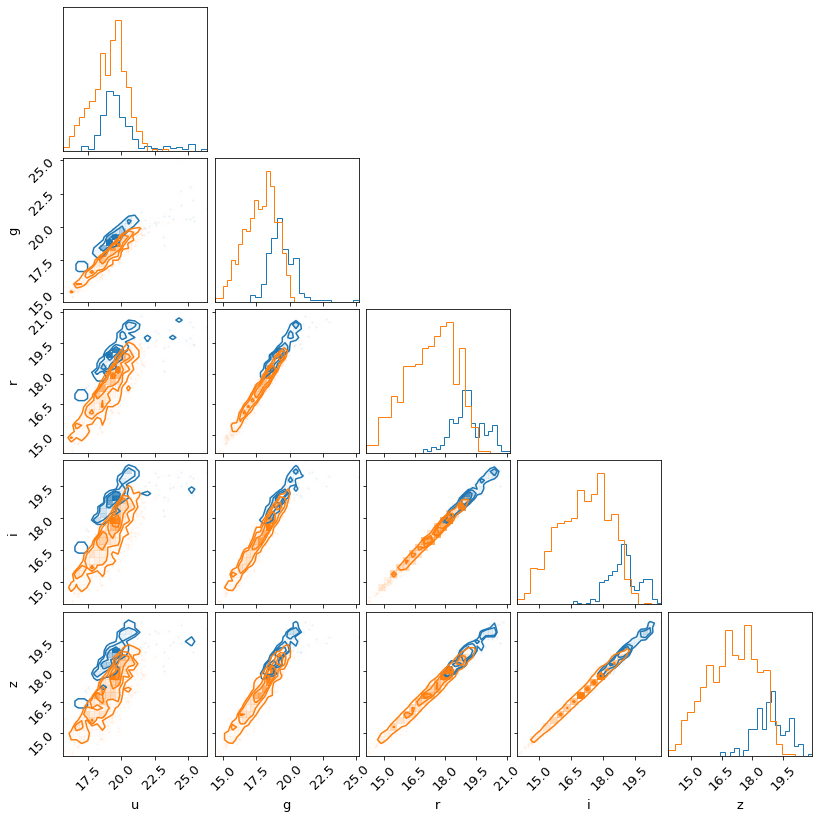

In [31]:
fig = corner.corner(X_QSO, color="C0")
corner.corner(X_star, fig=fig, color="C1");

#### task 3: **classify with SVC & test score**

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

model = SVC(kernel="linear")

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [34]:
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
y_pred = model.predict(X_test)
sum(y_pred == y_test) / len(y_pred)

0.9447004608294931

In [36]:
model.score(X_test, y_test)

0.9447004608294931

In [37]:
from sklearn.metrics import classification_report

In [38]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.936     0.830     0.880        53
           1      0.947     0.982     0.964       164

    accuracy                          0.945       217
   macro avg      0.942     0.906     0.922       217
weighted avg      0.944     0.945     0.944       217



In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.936     0.830     0.880        53
           1      0.947     0.982     0.964       164

    accuracy                          0.945       217
   macro avg      0.942     0.906     0.922       217
weighted avg      0.944     0.945     0.944       217



#### task 4: **rescale the data -> `X_scaled` & test score**

In [40]:
X_scaled = X.copy()
for col in X.columns:
    X_scaled[col] = (X[col] - np.mean(X[col])) / np.std(X[col])

In [41]:
X_scaled.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,-0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.61,-2.86,-2.65,-2.62,-2.59
25%,-0.57,-0.66,-0.72,-0.73,-0.73
50%,0.03,0.12,0.12,0.11,0.12
75%,0.53,0.69,0.77,0.78,0.77
max,5.15,5.24,2.52,2.32,2.51


In [42]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)
X_scaled.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.61,-2.86,-2.65,-2.62,-2.59
25%,-0.57,-0.66,-0.72,-0.73,-0.73
50%,0.03,0.12,0.12,0.11,0.12
75%,0.53,0.69,0.77,0.78,0.77
max,5.15,5.24,2.52,2.32,2.51


In [43]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(),
                      SVC(kernel="linear"))

model.fit(X_train, y_train)

model.score(X_train, y_train)

0.9415384615384615

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(),
                      SVC(kernel="linear"))

model.fit(X_train, y_train)

model.score(X_train, y_train)

0.9415384615384615

## **Feature selection & dimensionality reduction**

In [45]:
from sklearn.ensemble import ExtraTreesClassifier

In [46]:
clf = ExtraTreesClassifier(random_state=42).fit(X,y)
clf.feature_importances_

array([0.29715325, 0.11687197, 0.21442021, 0.19203806, 0.17951651])

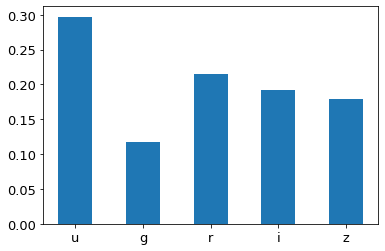

In [47]:
plt.bar(np.arange(5), clf.feature_importances_, 0.5)
plt.xticks(np.arange(5), X.columns);

#### task 5: **calculate spectral indices -> `X_new` & test importance**

In [48]:
X_new = X.copy()
X_new["new"] = np.ones(len(X_new.u))
X_new

,u,g,r,i,z,new
0,19.240999,17.525999,16.840000,16.613001,16.492001,1.0
1,19.732000,18.339001,17.767000,17.580000,17.481001,1.0
2,16.120001,15.232000,14.933000,14.845000,14.827000,1.0
3,18.995001,18.150999,17.877001,17.747000,17.766001,1.0
4,19.032000,18.112000,17.848000,17.709999,17.712000,1.0
...,...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000,1.0
863,26.433001,21.429001,20.261000,20.108000,20.073000,1.0
864,20.535999,20.200001,20.292999,19.910000,19.726000,1.0
865,20.627001,20.583000,20.270000,20.229000,20.190001,1.0


In [49]:
X_new = X.copy()
X_new["u-g"] = X.u - X.g
X_new["u-r"] = X.u - X.r
X_new["u-z"] = X.u - X.z
X_new["i-z"] = X.i - X.z

X_new

,u,g,r,i,z,u-g,u-r,u-z,i-z
0,19.240999,17.525999,16.840000,16.613001,16.492001,1.715000,2.400999,2.748999,0.121000
1,19.732000,18.339001,17.767000,17.580000,17.481001,1.393000,1.965000,2.250999,0.098999
2,16.120001,15.232000,14.933000,14.845000,14.827000,0.888000,1.187001,1.293001,0.018001
3,18.995001,18.150999,17.877001,17.747000,17.766001,0.844002,1.118000,1.229000,-0.019001
4,19.032000,18.112000,17.848000,17.709999,17.712000,0.920000,1.184000,1.320000,-0.002001
...,...,...,...,...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000,0.199999,0.584000,0.576000,-0.043999
863,26.433001,21.429001,20.261000,20.108000,20.073000,5.004000,6.172001,6.360001,0.035000
864,20.535999,20.200001,20.292999,19.910000,19.726000,0.335999,0.243000,0.809999,0.184000
865,20.627001,20.583000,20.270000,20.229000,20.190001,0.044001,0.357000,0.437000,0.039000


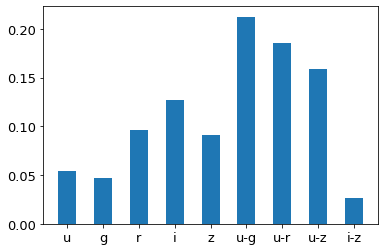

In [50]:
clf = ExtraTreesClassifier(random_state=42).fit(X_new,y)
plt.bar(np.arange(len(X_new.columns)), clf.feature_importances_, 0.5)
plt.xticks(np.arange(len(X_new.columns)), X_new.columns);

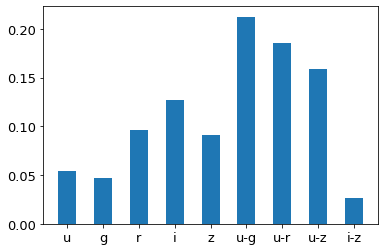

In [51]:
X_new = X.copy()
X_new["u-g"] = X.u - X.g
X_new["u-r"] = X.u - X.r
X_new["u-z"] = X.u - X.z
X_new["i-z"] = X.i - X.z

clf = ExtraTreesClassifier(random_state=42).fit(X_new,y)
plt.bar(np.arange(len(X_new.columns)), clf.feature_importances_, 0.5)
plt.xticks(np.arange(len(X_new.columns)), X_new.columns);

#### task 6: **test score for *u-r* spectral index**

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_new[["u-r"]], y, 
                                                    stratify=y, 
                                                    random_state=42)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9585253456221198

#### task 7: **create dummy column & test importance**

In [53]:
X_new3 = X.copy()

X_new3["dummy"] = np.random.normal(0, 1, size=len(X.r))
X_new3["dummy2"] = np.ones_like(X.r)

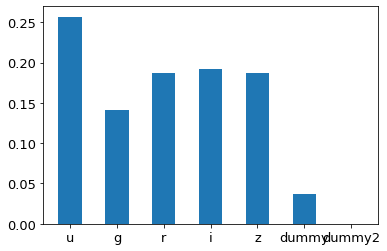

In [54]:
clf = ExtraTreesClassifier().fit(X_new3,y)
plt.bar(np.arange(len(X_new3.columns)), clf.feature_importances_, 0.5)
plt.xticks(np.arange(len(X_new3.columns)), X_new3.columns);

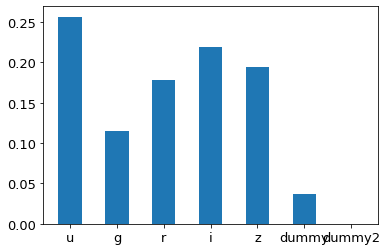

In [55]:
X_new3 = X.copy()

X_new3["dummy"] = np.random.normal(0, 1, size=len(X.r))
X_new3["dummy2"] = np.ones_like(X.r)

clf = ExtraTreesClassifier().fit(X_new3,y)
plt.bar(np.arange(len(X_new3.columns)), clf.feature_importances_, 0.5)
plt.xticks(np.arange(len(X_new3.columns)), X_new3.columns);

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_new3[["dummy"]], y, 
                                                    stratify=y, 
                                                    random_state=0)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.7557603686635944

In [57]:
sum(data["target"] == "star") / len(y), sum(data["target"] == "QSO") / len(y)

(0.7554786620530565, 0.24452133794694347)

### **Principal component analysis**

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_n = pca.fit_transform(X)

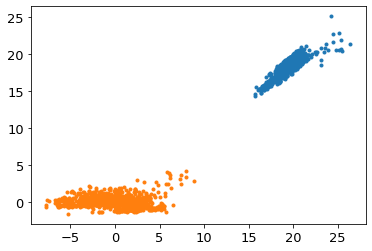

In [59]:
plt.plot(X.u, X.g, ".")
plt.plot(X_n[:,0], X_n[:,1], ".")

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_n, y, 
                                                    stratify=y, 
                                                    random_state=42)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9631336405529954

## **Tune hyperparameters**

In [61]:
SVC?

#### task 8: **find SVC hyperparameters with best test score**

In [62]:
def classify(X, y, classifier):
    model = make_pipeline(StandardScaler(),
                          classifier)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_test).round(3))

In [63]:
classify(X, y, SVC(kernel="linear"))

0.945


In [64]:
classify(X, y, SVC(kernel="linear", C=10))

0.959


In [65]:
classify(X, y, SVC(kernel="linear", C=0.1))

0.931


In [66]:
classify(X, y, SVC(kernel="poly", degree=1))

0.926


In [67]:
classify(X, y, SVC(kernel="rbf", C=100))

0.986


## **Crossvalidate**

In [68]:
from sklearn.model_selection import cross_validate

In [69]:
model = SVC(kernel="rbf", C=1000)

res = cross_validate(model, X, y, cv=10)

np.mean(res["test_score"]), np.std(res["test_score"])

(0.98040630847367, 0.012683091315102809)

### **Grid-search + crossvalidation**

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
clf = SVC()
params = {"C" : [0.01, 0.1, 1, 10, 100],
          "kernel" : ["linear", "poly", "rbf"]}#,
          #"gamma" : ["scale", "auto"]}
model = GridSearchCV(clf, params, cv=5, n_jobs=8)
model.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=8,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [72]:
model.cv_results_

{'mean_fit_time': array([ 0.02480063,  0.54897051,  0.05689406,  0.02101917,  2.82923484,
         0.04485388,  0.03195934, 12.24244113,  0.02838664,  0.06156931,
        15.82138147,  0.02574139,  0.28332977, 15.72574387,  0.03037953]),
 'mean_score_time': array([0.00804505, 0.00576434, 0.01521573, 0.00601034, 0.00827703,
        0.01588249, 0.01033907, 0.00590262, 0.00788178, 0.00711689,
        0.0053946 , 0.0075367 , 0.00653138, 0.001261  , 0.00926576]),
 'mean_test_score': array([0.88470534, 0.96194273, 0.75548469, 0.93543951, 0.97117799,
        0.94581091, 0.9458242 , 0.97463291, 0.96541094, 0.94812969,
        0.97810112, 0.98039333, 0.94927912, 0.9769517 , 0.97925055]),
 'param_C': masked_array(data=[0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1, 1, 1, 10, 10, 10,
                    100, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False],
        fill_value='?',
             dtype=ob

In [73]:
params, score = model.cv_results_["params"], model.cv_results_["mean_test_score"]

indices = np.argsort(score)

for i in indices:
    print(params[i], score[i].round(3))

{'C': 0.01, 'kernel': 'rbf'} 0.755
{'C': 0.01, 'kernel': 'linear'} 0.885
{'C': 0.1, 'kernel': 'linear'} 0.935
{'C': 0.1, 'kernel': 'rbf'} 0.946
{'C': 1, 'kernel': 'linear'} 0.946
{'C': 10, 'kernel': 'linear'} 0.948
{'C': 100, 'kernel': 'linear'} 0.949
{'C': 0.01, 'kernel': 'poly'} 0.962
{'C': 1, 'kernel': 'rbf'} 0.965
{'C': 0.1, 'kernel': 'poly'} 0.971
{'C': 1, 'kernel': 'poly'} 0.975
{'C': 100, 'kernel': 'poly'} 0.977
{'C': 10, 'kernel': 'poly'} 0.978
{'C': 100, 'kernel': 'rbf'} 0.979
{'C': 10, 'kernel': 'rbf'} 0.98


In [74]:
model.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## **Compare classifiers**

In [75]:
from sklearn.neural_network import MLPClassifier # multi-layer perceptron classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [76]:
classifiers = [MLPClassifier(max_iter=1000),
               GaussianNB(),
               DecisionTreeClassifier(),
               KNeighborsClassifier(),
               SVC(kernel="rbf", C=10)]

for classifier in classifiers:
    classify(X, y, classifier)

0.977
0.779
0.954
0.968
0.986


In [77]:
clf = MLPClassifier(max_iter=1000)
params = {"hidden_layer_sizes" : [5, 10, 50, 100],
          "activation" : ["identity", "logistic", "tanh", "relu"],
          "solver" : ["sgd", "adam"]}
model = GridSearchCV(clf, params, cv=5, n_jobs=8)
model.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=1000, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'

In [78]:
model.best_estimator_, model.best_score_

(MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=100, learning_rate='constant',
               learning_rate_init=0.001, max_fun=15000, max_iter=1000,
               momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
               power_t=0.5, random_state=None, shuffle=True, solver='sgd',
               tol=0.0001, validation_fraction=0.1, verbose=False,
               warm_start=False), 0.9515779682413129)

In [79]:
%time MLPClassifier(hidden_layer_sizes=10, max_iter=1000, solver='sgd').fit(X_train, y_train).score(X_test, y_test)

CPU times: user 1.01 s, sys: 65.2 ms, total: 1.08 s
Wall time: 1 s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9723502304147466

In [80]:
%time SVC(C=10).fit(X_train, y_train).score(X_test, y_test)

CPU times: user 4.53 ms, sys: 721 µs, total: 5.25 ms
Wall time: 6.32 ms


0.9861751152073732

## **Ensemble methods**

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
model = RandomForestClassifier()

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9630446404704627, 0.017810656727055927)

In [83]:
from sklearn.ensemble import StackingClassifier

In [84]:
classifiers = [("MLP", MLPClassifier(max_iter=1000, random_state=42)),
               ("Bayes", GaussianNB()),
               ("RFC", RandomForestClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC(C=10))]

model = StackingClassifier(classifiers)

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9792301523656777, 0.013441802533860854)

In [85]:
classifiers = [("MLP", MLPClassifier(max_iter=1000, random_state=42)),
               ("Bayes", GaussianNB()),
               ("DTC", DecisionTreeClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC(C=10))]

# train the model
clf = StackingClassifier(classifiers)

model = make_pipeline(StandardScaler(),
                      clf)

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

(0.9815290029403902, 0.01059950351622488)

## **Conclusion**

In [86]:
classifiers = [("MLP", MLPClassifier(max_iter=1000, random_state=42)),
               ("Bayes", GaussianNB()),
               ("DTC", DecisionTreeClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC(C=10))]

# train the model
clf = StackingClassifier(classifiers)

model = make_pipeline(StandardScaler(),
                      clf)

model.fit(X_new[["u-g"]], y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('stackingclassifier',
                 StackingClassifier(cv=None,
                                    estimators=[('MLP',
                                                 MLPClassifier(activation='relu',
                                                               alpha=0.0001,
                                                               batch_size='auto',
                                                               beta_1=0.9,
                                                               beta_2=0.999,
                                                               early_stopping=False,
                                                               epsilon=1e-08,
                                                               hidden_layer_sizes=(100,),
                                                               learning_rate='con

In [87]:
u = 15.914
g = 15.500

pred = model.predict(np.array([u-g]).reshape(-1,1))

le.inverse_transform(pred)

array(['QSO'], dtype=object)

# **OpenAI**

In [88]:
'''
1. generate 2 dimesional data with two distinct classes.
2. scale the using min-max scaler.
3. classify the data using random forest classifier.
4. find best hyperparameters using grid search.
'''

'\n1. generate 2 dimesional data with two distinct classes.\n2. scale the using min-max scaler.\n3. classify the data using random forest classifier.\n4. find best hyperparameters using grid search.\n'

### **Compare classifiers**

In [89]:
# '''
# 1. generate 2 dimensional data with two distinct classes.
# 2. classify the data using various classifiers.
# 3. compare the classifiers.
# '''

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # generate data
# np.random.seed(0)
# x1 = np.random.normal(size=(100, 2))
# x2 = np.random.normal(loc=2, size=(100, 2))
# x = np.vstack((x1, x2))
# y = np.array([0] * 100 + [1] * 100)

# # split data
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# # classifiers
# classifiers = [
#     LogisticRegression(),
#     KNeighborsClassifier(),
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     SVC()
# ]

# # train and test
# for clf in classifiers:
#     clf.fit(x_train, y_train)
#     y_pred = clf.predict(x_test)
#     print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

# # plot
# plt.scatter(x[:, 0], x[:, 1], c=y, s=100, lw=0, cmap='RdYlGn')
# plt.show()

### **Grid search**

In [90]:
# '''
# 1. generate 2 dimesional data with two distinct classes.
# 2. classify the data using random forest classifier.
# 3. find best hyperparameters using grid search.
# '''

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # generate data
# mean1 = [1, 0]
# cov1 = [[1, 0.1], [0.1, 1]]
# mean2 = [0, 1.5]
# cov2 = [[1, 0.1], [0.1, 1]]
# dist1 = np.random.multivariate_normal(mean1, cov1, 500)
# dist2 = np.random.multivariate_normal(mean2, cov2, 500)

# # plot data
# plt.scatter(dist1[:, 0], dist1[:, 1], color='red')
# plt.scatter(dist2[:, 0], dist2[:, 1], color='green')
# plt.show()

# # prepare data for classification
# data = np.zeros((1000, 3))
# data[:500, :2] = dist1
# data[500:, :2] = dist2
# data[500:, -1] = 1

# # split data into training and testing
# X_train, X_test, y_train, y_test = train_test_split(data[:, :2], data[:, -1])

# # train the model
# model = RandomForestClassifier()
# model.fit(X_train, y_train)

# # predict
# y_pred = model.predict(X_test)

# # find accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(accuracy)

# # find best hyperparameters using grid search
# from sklearn.model_selection import GridSearchCV

# params = {'n_estimators': [10, 20, 30], 'max_depth': [2, 5, 7]}

# grid_search = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [91]:
# '''
# 1. generate 2 dimesional data with two distinct classes.
# 2. scale the using min-max scaler.
# 3. classify the data using random forest classifier.
# 4. find best hyperparameters using grid search.
# '''

# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.datasets import make_blobs

# # generate 2d classification dataset
# X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

# # scale the data
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

# # split into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

# # define the model
# model = RandomForestClassifier()

# # define the grid search parameters
# n_estimators = [100, 300, 500]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10]

# # define the grid
# param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)#, min_samples_leaf=min_samples_leaf)

# # define the grid search
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=5, verbose=1, return_train_score=True)

# # fit the grid search
# grid_result = grid_search.fit(X_train, y_train)

# # summarize the results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# # plot the results
# scores = np.array(means).reshape(len(max_depth), len(n_estimators))
# for i, value in enumerate(max_depth):
#     plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
# plt.legend()
# plt.xlabel('n_estimators')
# plt.ylabel('Mean Accuracy')
# plt.show()